In [1]:
# !jupyter nbconvert --to script ./test.ipynb

[NbConvertApp] Converting notebook ./test.ipynb to script
[NbConvertApp] Writing 1768 bytes to ./test.py


In [1]:
import os
os.chdir('/workspace/my_cyclegan')

from options.train_options import TrainOptions
from dataloader import create_dataset
from models import create_model
from util.visualizer import Visualizer

import time
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
opt = TrainOptions().parse(isCodeCheck=True)
opt.batch_size = 1
dataset = create_dataset(opt)  
dataset_size = len(dataset)    # get the number of images in the dataset.
print('The number of training images = %d' % dataset_size)
vis = Visualizer(opt)

----------------- Options ---------------
               batch_size: 5                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
             data_shuffle: True                          
                 dataroot: /all_data/hdd/un_depth/semi/sample
             dataset_mode: semi_cycle                    
         disc_for_normals: False                         
                  dropout: True                          
              epoch_count: 1                             
                 gan_mode: lsgan                         
                  gpu_ids: 2                             
                 img_freq: 1                             
                init_type: normal                        
           input_nc_depth: 1                             
             input_nc_img:

5
5
55

55

55

5
5
5
5
5
55

5
55



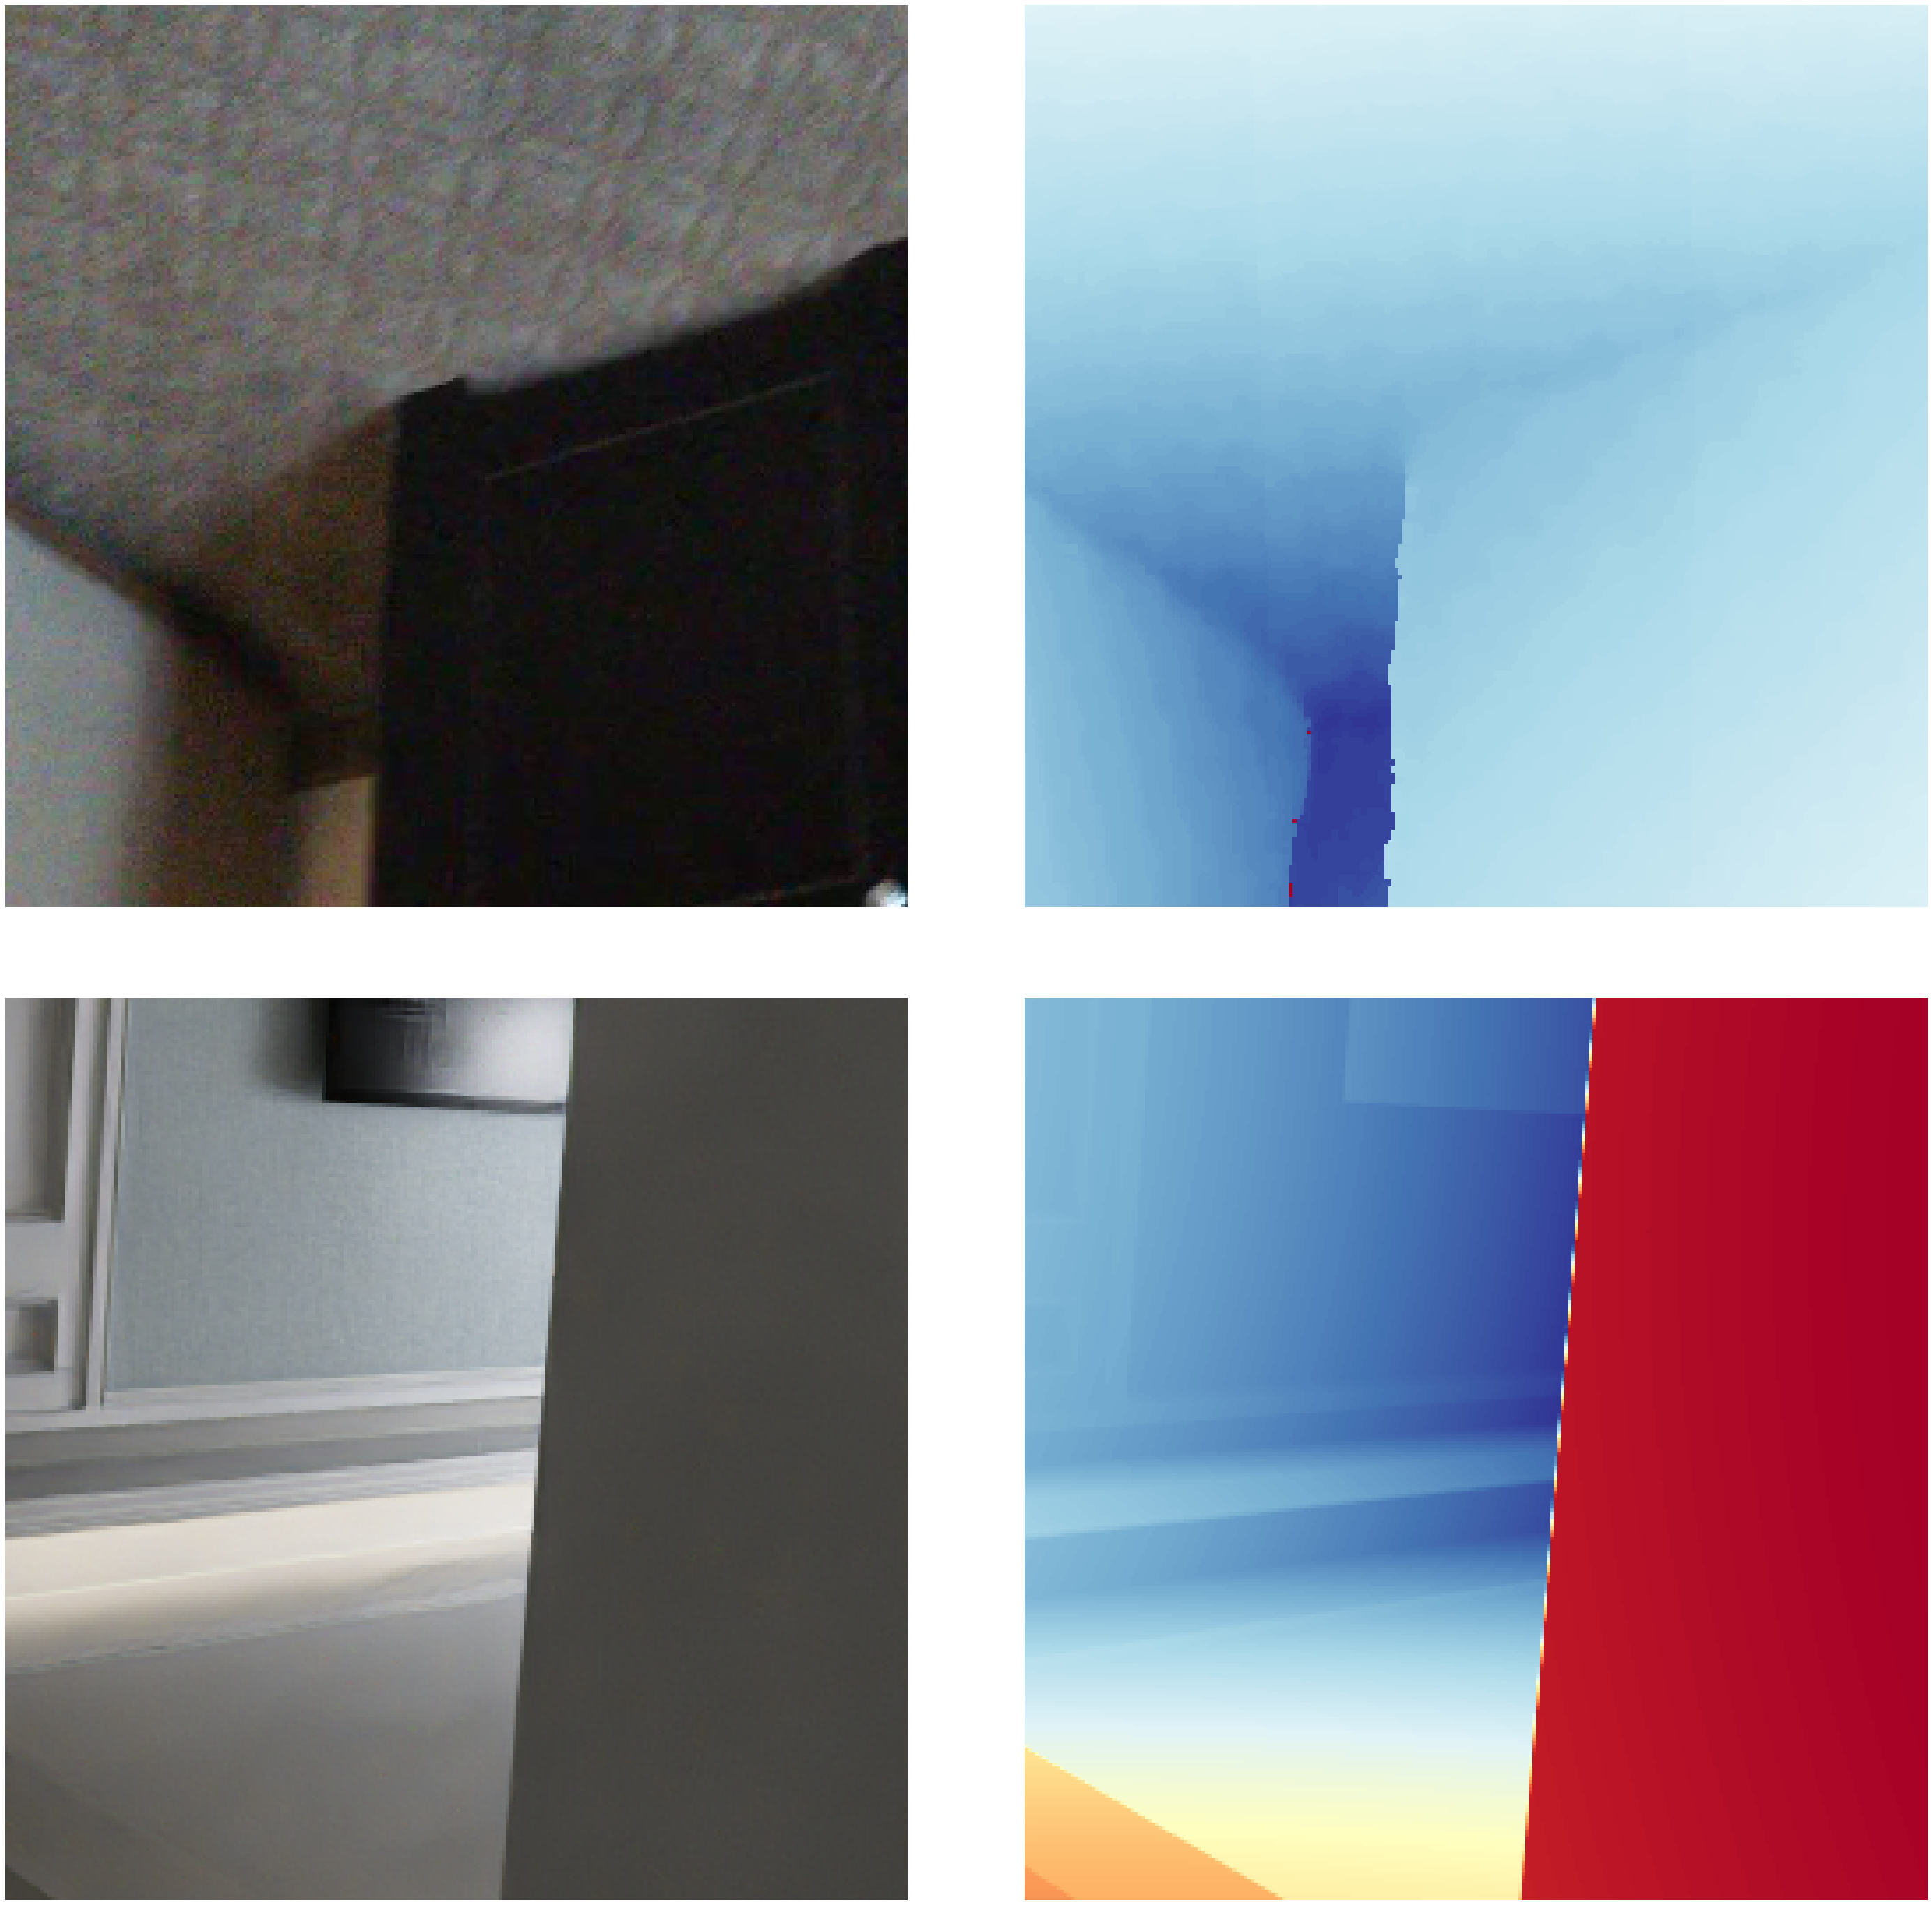

In [3]:
for data in dataset:
    vis.plot_batch(data)
    break

In [5]:
opt.isTrain

True

In [4]:
model = create_model(opt)      # create a model given opt.model and other options
model.setup()

initialize network with normal
initialize network with normal
initialize network with normal
loading the model from ./checkpoints/holes/last_Unet.pth
model [A2BModel] was created
---------- Networks initialized -------------
[Network netG_A] Total number of parameters : 30.031 M
[Network netD_A] Total number of parameters : 2.763 M
-----------------------------------------------


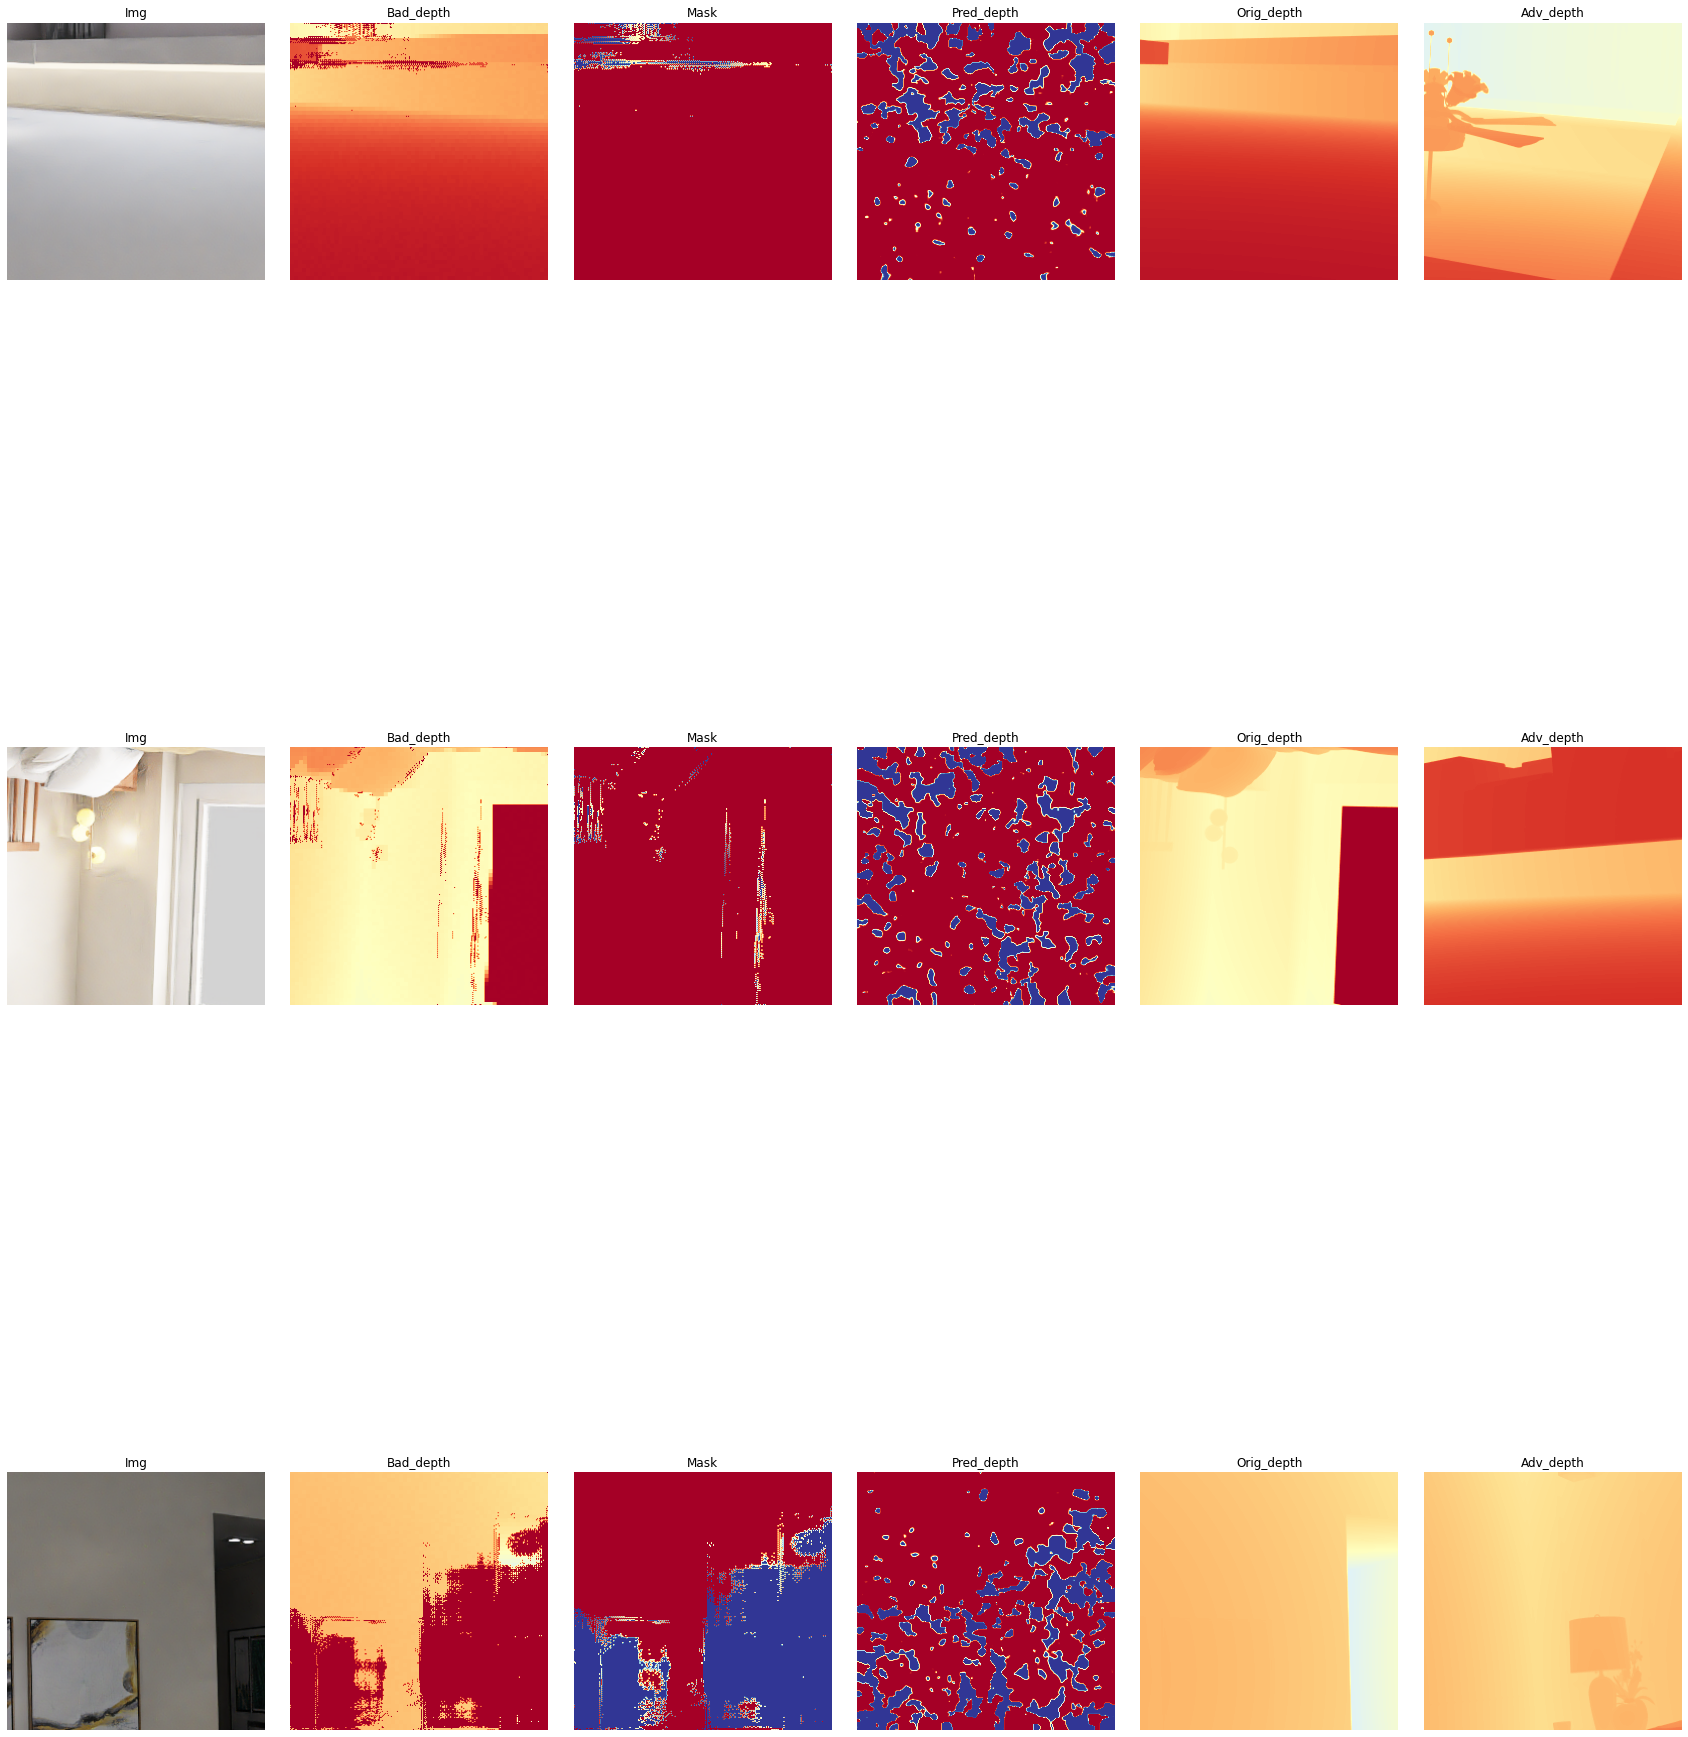

In [5]:
for data in dataset:
    model.set_input(data)
    model.optimize_param()
    vis.plot_a2b(model.get_current_vis())
    break

In [6]:
model.get_current_losses()

OrderedDict([('D_A_depth', 6107.267578125),
             ('G_A', 6518.48193359375),
             ('depth_range_A', 0.7810897827148438)])

In [5]:
model.real_semantic_A.min()

AttributeError: 'HolesUnetModel' object has no attribute 'real_semantic_A'

In [6]:
model.rec_semantic_A.shape

torch.Size([5, 40, 256, 256])

In [5]:
data['A_semantic'].dtype

torch.int64

In [6]:
import imageio
import matplotlib.pyplot as plt

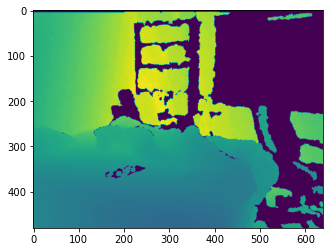

In [11]:
a = imageio.imread('/all_data/hdd/un_depth/semi/sample/testA/depth/scene0092_01_200.png')
plt.imshow(a)

In [1]:
import os
os.chdir('/workspace/my_cyclegan')

In [6]:
# !python train.py --dataroot /all_data/hdd/un_depth/semi/sample\
# --gpu_ids 1\
# --name test\
# --gan_mode vanilla\
# --use_blur\
# --netG resnet_6blocks\
# --ngf_depth 20\
# --ngf_rgb 32\
# --ngf_depth_edge 16\
# --ndf 64\
# --netD n_layers\
# --n_layers_D 3\
# --l_depth_large_A 70\
# --l_depth_small_A 70\
# --l_depth_large_B 10\
# --l_depth_small_B 10\
# --l_depth_max_iter 30000\
# --lambda_cycle_A 5.0\
# --lambda_identity 2.5\
# --lambda_reconstruction 0.0\
# --max_dataset_size 18\
# --batch_size 6\
# --load_size_h 480\
# --load_size_w 640\
# --lr_D 0.0003\
# --lr_G 0.0002\
# --num_iter_gen 3\
# --norm instance\
# --init_type xavier\
# --beta1 0.5\
# --img_freq 1\
# --loss_freq 1\
# --save_epoch_freq 10\
# --n_epochs 10\
# --n_epochs_decay 5\
# # --netG_d2e unet_256\
# # --net_d2e_weights './checkpoints/depth_edge_unet_1.5_weight_binatyloss/last_netG_B.pth'\